In [1]:
%matplotlib inline

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib as mpl
import matplotlib.pyplot as plt

from svgd import SVGD

Define a function that performs a search over the kernel parameter space:

In [3]:
def get_mse(logp, n, stepsize, L, m, q, kernel_param_update_rule=None):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * m: integer, number of samples for averaging MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0
    * kernel_param_update_rule: callable, takes the updated particles as input and outputs an updated set of kernel parameters.
    If kernel_param constant, set to lambda x: const

    OUT:
    * dictionary of MSE values

    """
    mse1 = []
    mse2 = []
    mse3 = []
    for seed in range(0, m):
        key = random.PRNGKey(seed)
        x = q(key, n)

        xout, log = svgd(x, logp, stepsize, L, kernel_param_update_rule)
        mse1.append((np.mean(xout) - 2/3)**2)
        mse2.append((np.mean(xout**2) - 5)**2)

        w = random.normal(key, (1,))
        mse3.append((np.mean(np.cos(w * xout) - np.exp(-w**2 / 2))**2))

    mse1 = np.mean(np.array(mse1))
    mse2 = np.mean(np.array(mse2))
    mse3 = np.mean(np.array(mse3))

    mse = {
    "E[x]": mse1,
    "E[x^2]": mse2,
    "E[cos(wx)]": mse3
    }
    
    return mse

In [3]:
default_q = lambda key, n: random.normal(key, shape=(n,1)) - 10
def kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q=default_q):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * kernel_param_grid: one-dimensional np array
    * m: integer, number of samples for computing MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0

    
    OUT:
    * dictionary consisting of three np arrays of the same length as kernel_param_grid. Entries are MSE values.
    """
    logs = []
    mse1s = []
    mse2s = []
    mse3s = []

    for h in kernel_param_grid:
        mse1, mse2, mse3 = list(get_mse(logp, n, stepsize, L, m, q, lambda x: h).values())
        
        mse1s.append(mse1)
        mse2s.append(mse2)
        mse3s.append(mse3)
    
    mses = {
        "E[x]": mse1s,
        "E[x^2]": mse2s,
        "E[cos(wx)]": mse3s
    }
    
    return mses

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


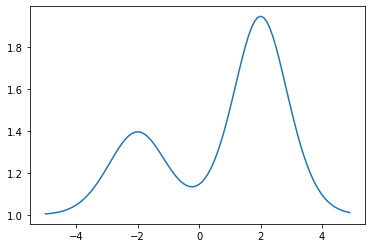

In [2]:
from utils import log_gaussian_mixture

logp = lambda x: log_gaussian_mixture(x, means=[-2, 2], variances=[1, 1], weights=[1/3, 2/3])

grid = np.arange(-5, 5, 0.1)
vlogp = vmap(logp)
_ = plt.plot(grid, np.exp(vlogp(grid)))

In [6]:
n = 100
stepsize = 0.01
L = int(1 / stepsize)
kernel_param_grid = np.logspace(-10, 15, num=25, base=2) # params smaller than 2^10 are generally awful
m = 30


q1 = lambda key, n: random.normal(key, shape=(n,1)) - 10
q2 = lambda key, n: random.normal(key, shape=(n,1)) * 2 + 10

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4665: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4665: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [7]:
mses1 = kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q1)
mses2 = kernel_param_search(logp, n, stepsize, L, m, kernel_param_grid, q2)

KeyboardInterrupt: 

For comparison, do the same estimates using an adaptive kernel parameter:

In [ ]:
from svgd import kernel_param_update_rule
mses_adaptive1 = get_mse(logp, n, stepsize, L, m, q1, kernel_param_update_rule)
mses_adaptive2 = get_mse(logp, n, stepsize, L, m, q2, kernel_param_update_rule)

In [ ]:
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
plt.subplots_adjust(hspace=0.8, wspace=0.6)
colours = ['r', 'b', 'g']

for i, yaxis_name in enumerate(['E[x]', 'E[x^2]', 'E[cos(wx)]']):
    col = colours[i]
    
    # first q
    ax1 = plt.subplot(f'32{2*i+1}')
    plt.title("Initial distribution N(-10, 1)")
    plt.plot(kernel_param_grid, mses1[yaxis_name], col)
    plt.axhline(y=mses_adaptive1[yaxis_name])

    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(yaxis_name)
    

    # second q
    ax2 = plt.subplot(f'32{2*i+2}')
    plt.title("Initial distribution N(10, 4)")
    plt.plot(kernel_param_grid, mses2[yaxis_name], col)
    plt.axhline(y=mses_adaptive2[yaxis_name])
    
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel(yaxis_name)
    
    
    # adapt y-axis range: same ranges for both plots
    min1, max1 = ax1.get_ylim()
    min2, max2 = ax2.get_ylim()
    
    ax1.set_ylim(min(min1, min2), max(max1, max2))
    ax2.set_ylim(min(min1, min2), max(max1, max2))

Figure: Mean squared error (y-axis) vs. kernel parameter values (x-axis). The horizontal lines indicate the MSE obtained when computing the estimate using an adaptive kernel.
* Red: MSE when estimating $E[X]$.
* Green: MSE when estimating $E[X^2]$.
* Blue: MSE when estimating $E[\cos(\omega X)]$.

Columns:
* Left column: results for initial distribution $q_0 \sim \mathcal N(-10, 1)$.
* Right column: results for initial distribution $q_0 \sim \mathcal N(10, 4)$.

## Search parameters of initial distribution

In [ ]:
default_q = lambda key, n: random.normal(key, shape=(n,1)) - 10
def q_param_search(logp, kernel_param, n, stepsize, L, param_grid, m=20, kernel_param_update_rule=None):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * param_grid: one-dimensional np array
    * m: integer, number of samples for computing MSE
    
    OUT:
    * dictionary consisting of three np arrays of the same length as kernel_param_grid. Entries are MSE values.
    """
    logs = []
    mse1s = []
    mse2s = []
    mse3s = []

    for param in param_grid:
        q = lambda key, n: random.normal(key, shape=(n,1)) * param[1] + param[0]
        mse1, mse2, mse3 = list(get_mse(logp, n, stepsize, L, m, q, kernel_param, kernel_param_update_rule).values())

        mse1s.append(mse1)
        mse2s.append(mse2)
        mse3s.append(mse3)

    mses = {
        "E[x]": mse1s,
        "E[x^2]": mse2s,
        "E[cos(wx)]": mse3s
    }
    
    return mses

In [ ]:
n = 100
stepsize = 0.01
L = int(1 / stepsize)
stdev = 1
param_grid = [(mean, stdev) for mean in np.arange(-20, 20, 1)]
m = 30
kernel_param = 5

In [ ]:
from svgd import kernel_param_update_rule

mse_dict_fix = q_param_search(logp, kernel_param, n, stepsize, L, param_grid, m)
mse_dict_adap = q_param_search(logp, None, n, stepsize, L, param_grid, m, kernel_param_update_rule)

param_grid = [param[0] for param in param_grid] # just wanna plot wrt the means

In [ ]:
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
plt.subplots_adjust(hspace=0.8, wspace=0.5)
colours = ['r', 'b', 'g']

for i, yaxis_name in enumerate(['E[x]', 'E[x^2]', 'E[cos(wx)]']):
    col = colours[i]
    
    # fixed kernel
    ax1 = plt.subplot(f'32{2*i+1}')
    plt.title(f"Fixed kernel parameter h = {kernel_param}")
    plt.plot(param_grid, mses_dict_fix[yaxis_name], col)
    plt.yscale('log')
    plt.ylabel(yaxis_name)
    
    # adaptive kernel
    ax2 = plt.subplot(f'32{2*i+2}')
    plt.title(f"Adaptive kernel parameter")
    plt.plot(param_grid, mses_dict_adap[yaxis_name], col)
    plt.yscale('log')
    plt.ylabel(yaxis_name)
    
    # adapt y-axis range: same ranges for both plots
    min1, max1 = ax1.get_ylim()
    min2, max2 = ax2.get_ylim()
    
    ax1.set_ylim(min(min1, min2), max(max1, max2))
    ax2.set_ylim(min(min1, min2), max(max1, max2))